# Simulation plots

In [2]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [94]:
#IMPORTANT: which_host is always a array index (0,1,2), 
#_i is always index from the catalogue, 
#and _ids is id from the catalogue
class SimTools():
    def __init__(self, catalogue, snapshot, membership_file, siminfo_file, volume_num):
        self.catalogue_file = catalogue
        self.snapshot = snapshot
        self.membership_file = membership_file
        self.siminfo_file = siminfo_file
        self.mstar = None
        self.mtotal = None
        self.soap = h5py.File(self.catalogue_file, 'r') # Read in SOAP property file
        self.field = np.array(self.soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
        self.vol = volume_num
        self.halo_ids = self.soap['VR/ID']
        self.halo_i = np.array(self.halo_ids)-1
        self.host_halo_ids = np.array(self.soap['VR/ID'])[self.field==-1]
        
        with open(self.siminfo_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if 'h_val' in line:
                parts = line.split()
                self.h_val = float(parts[2])
                break
        
    def getHaloMasses(self):
        self.mtotal = np.array(self.soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
        self.mstar = np.array(self.soap['ExclusiveSphere/30kpc/StellarMass'])

        return self.mtotal, self.mstar

    def getHaloDarkMatterMembers(self, halo_index):
        #halo INDEX is not halo ID
        # function to read in bound DM particles for a given halo
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType1/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_index) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.positions

    def getHaloStarsMembers(self, halo_index):
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_index) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.star_positions
    
    def calc_r200(self, which_host):
        host_i = self.central_massive_halo_i[which_host]
        m200 = np.array(self.soap['SO/200_crit/TotalMass'])[host_i] #mass is in solar mass
        
        H = self.h_val*100 #converting from H/100 to h
        G = 4.3e-9 #converting from pc to Mpc
        rho_crit = 3*(H**2)/(8*np.pi*G)
        r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
        return r200
            
    def make_volume_table(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        host_r200 = [self.calc_r200(i) for i in range(len(self.central_massive_halo_i))]
        host_CoM = np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])[self.central_massive_halo_i]
        host_tot_mass = [self.mtotal[i] for i in self.central_massive_halo_i]
        host_stellar_mass = [self.mstar[i] for i in self.central_massive_halo_i]
        sat_CoM = []
        sat_tot_mass = []
        sat_stellar_mass = []
        for i in self.sat_i:
            sat_CoM.append(np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])[i])
            sat_tot_mass.append(self.mtotal[i])
            sat_stellar_mass.append(self.mstar[i])
        #sat_CoM = np.array(sat_CoM)
        #sat_tot_mass = np.array(sat_tot_mass)
        #sat_stellar_mass = np.array(sat_stellar_mass)
        vol = np.full(len(self.central_massive_halo_i), self.vol)

        data_array = [vol, self.central_massive_halo_i, self.central_massive_halo_ids, host_r200, 
                      host_CoM, host_tot_mass, host_stellar_mass, 
                      self.sat_ids, self.sat_i, sat_CoM,
                      sat_tot_mass, sat_stellar_mass]
        col_labels = ['Volume', 'Host Halo i', 'Host Halo ID', 'Host R200', 
                      'Host CoM', 'Host Mtot', 'Host M*', 'Sat i', 'Sat ID', 
                      'Sat CoM', 'Sat Mtot', 'Sat M*']
        #print(len(data_array), len(col_labels))
        df = pd.DataFrame(data = data_array)#, columns = col_labels)
        df = df.transpose()
        df.columns = col_labels
        return df
    
    def getCentralHalos(self, mass_cut=True):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        center = np.array([float(c) for c in centers.loc[self.vol]])
        halo_centers = np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])

        #get massive host halos
        host_halo_mstar = self.mstar[self.field==-1] #mstar is all halo stellar masses
        massive_host_halo_ids = self.host_halo_ids[host_halo_mstar>1e9]
        massive_host_halo_i = massive_host_halo_ids - 1
        massive_halo_centers = halo_centers[massive_host_halo_i]
        
        #get centers within 5Mpc
        self.central_massive_halo_ids = []
        for i, c in enumerate(massive_halo_centers):
            if center[0]-5 <= c[0] <= center[0]+5 and center[1]-5 <= c[1] <= center[1]+5 and center[2]-5 <= c[2] <= center[2]+5:
                self.central_massive_halo_ids.append(massive_host_halo_ids[i])
        self.central_massive_halo_ids = np.array(self.central_massive_halo_ids)
        self.central_massive_halo_i = self.central_massive_halo_ids - 1
        
        #now get their satellites        
        self.sat_ids = []
        self.sat_i = []
        for central_halo_id in self.central_massive_halo_ids:
            sat_ids = self.halo_ids[self.field==central_halo_id]
            sat_i = np.array(sat_ids)-1
            self.sat_ids.append(sat_ids)
            self.sat_i.append(sat_i)
                
        return self.central_massive_halo_ids, self.central_massive_halo_i, self.sat_ids, self.sat_i
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.mtotal[self.field==-1])))
        axs[1].hist(np.log10(np.ma.array(self.mstar[self.field==-1])))
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'r','--')
        fig.suptitle('Field Halo mass distributions')
        fig.show()
    
    def plotBoxParticleDistribution(self):
        data = sw.load(self.snapshot_file) #read final snapshot
        pos = data.dark_matter.coordinates
        plt.figure(dpi=200)
        plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
        side_length = 0.20
        center_x = 381.5
        center_y = 160
        # Calculate the bottom left corner of the square
        bottom_left_x = center_x - side_length / 2
        bottom_left_y = center_y - side_length / 2

        # Square box around the center
        #square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')
        #plt.gca().add_patch(square_box)
        plt.show()

    def plot_particles(self, which_host=0):
        host_num = self.central_massive_halo_ids[which_host]
        host_halo_part = self.getHaloDarkMatterMembers(host_num-1)
        host_star_part = self.getHaloStarsMembers(host_num-1)
        sat_halo_part = []
        sat_star_part = []
        for i in self.sat_ids[which_host]:
            sat_halo_part.append(self.getHaloDarkMatterMembers(i-1))
            sat_star_part.append(self.getHaloStarsMembers(i-1))    
        sat_halo_part = np.array(sat_halo_part)
        sat_star_part = np.array(sat_star_part)
        fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
        ax[0].scatter(host_halo_part[:,1], host_halo_part[:,2], s=1, alpha = 0.2, c='black')
        ax[1].scatter(host_star_part[:,1], host_star_part[:,2], s=1, alpha = 0.2, c='black')
        for sat in sat_halo_part:
            ax[0].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
        for sat in sat_star_part:
            ax[1].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
        ax[1].set_title(f'Star particles of halo {self.central_massive_halo_ids[which_host]} and satellites')
        ax[0].set_title(f'Dark matter particles of halo {self.central_massive_halo_ids[which_host]} and satellites')
        fig.show()
    
    def number_plots(self):
        
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        
        for which_host in range(len(self.central_massive_halo_i)):
            r200 = self.calc_r200(which_host)
            sat_i = self.sat_i[which_host]
            host_i = self.central_massive_halo_i[which_host]
            host_center = self.soap['BoundSubhaloProperties/CentreOfMass'][host_i]
            satellite_centers = np.array(self.soap['BoundSubhaloProperties/CentreOfMass'][sat_i])
            distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000
            print(len(sat_i), len(distances))

            # Distance cut of satellites
            distance_mask = distances < r200
            new_sat_i = sat_i[distance_mask]
            distances = distances[distance_mask]

            # Total mass cut of satellites
            mass_mask = self.mtotal[new_sat_i] > 10**(7.5)
            new_sat_i = new_sat_i[mass_mask]
            distances = distances[mass_mask]

            arrays = {
                'distance': distances,
                'distance_norm': distances / r200,
                'mstar': self.mstar[new_sat_i], 
                'mtotal': self.mtotal[new_sat_i], 
                'mstar_norm': self.mstar[new_sat_i] / self.mstar[host_i], 
                'mtotal_norm': self.mtotal[new_sat_i] / self.mtotal[host_i]
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for i, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'distance' or key == 'distance_norm':
                    y_values = np.linspace(len(x_values) + 1, 1, len(x_values))
                else:
                    ax_flat[i].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)

                # Plot the values with a label for the host index
                ax_flat[i].plot(x_values, y_values, '-', label=f'Host {which_host}')
                ax_flat[i].set_title(key)
                ax_flat[i].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel('$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle('Central halo satellite properties')

        plt.show()


[array([378.70935 ,  59.600876, 159.14276 ], dtype=float32)
 array([379.47266 ,  60.625595, 158.08665 ], dtype=float32)
 array([382.34055,  61.09489, 156.16888], dtype=float32)]
0
1
2


C:\Users\prera\AppData\Local\Temp\ipykernel_19272\399416677.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


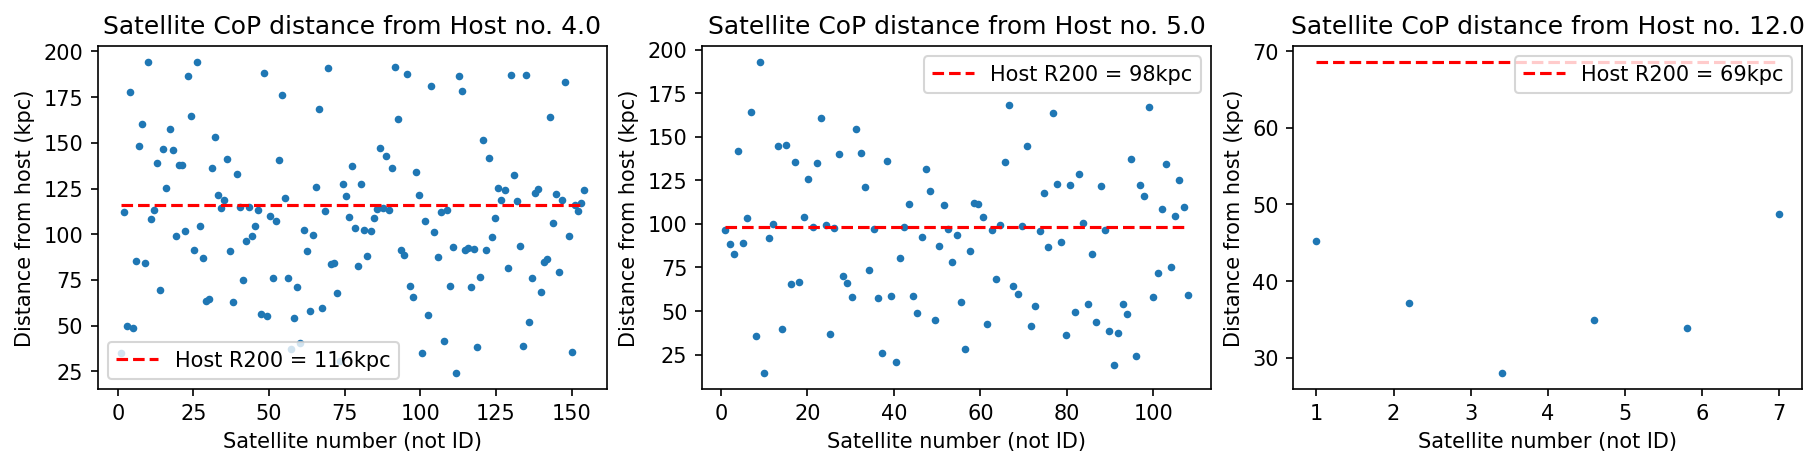

In [95]:
#SOAP_fname = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5'
#SOAP_membership = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_membership_0063.hdf5'
#snapshot = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5'
#siminfo_file = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/halo_0063.siminfo'
SOAP_fname = 'data/SOAP_halo_properties_0063.hdf5'
SOAP_membership = 'data/SOAP_membership_0063.hdf5'
snapshot = 'data/snapshot_0063.hdf5'
siminfo_file = 'data/halo_0063.siminfo'

vol15_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, 15)
#vol15_sim.StellarMassHaloMass_all()
#vol15_sim.FieldHaloMassDist()
#vol15_sim.BoxParticleDistribution()
vol15_sim.getCentralHalos()
vol15_df = vol15_sim.make_volume_table()

fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_centers = np.array(vol15_df['Host CoM'])
print(central_centers)
for i, host_center in enumerate(central_centers):
    print(i)
    sat_centers = np.array(vol15_df['Sat CoM'].iloc[i])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in sat_centers])*1000 #inkpc
    x = np.linspace(1, len(distances)+1, len(distances))
    ax_flat[i].scatter(x, distances, s = 7)
    r200 = vol15_df['Host R200'].iloc[i]
    ax_flat[i].hlines(r200, min(x), max(x), 'r', '--', label = f'Host R200 = {r200:.0f}kpc')
    ax_flat[i].set_xlabel('Satellite number (not ID)')
    ax_flat[i].set_ylabel('Distance from host (kpc)')
    ax_flat[i].set_title(f'Satellite CoP distance from Host no. {vol15_central_halos[i]+1}')
    ax_flat[i].legend()
fig.show()

Index(['Volume', 'Host Halo i', 'Host Halo ID', 'Host R200', 'Host CoM',
       'Host Mtot', 'Host M*', 'Sat i', 'Sat ID', 'Sat CoM', 'Sat Mtot',
       'Sat M*'],
      dtype='object')


C:\Users\prera\AppData\Local\Temp\ipykernel_19272\2195450335.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


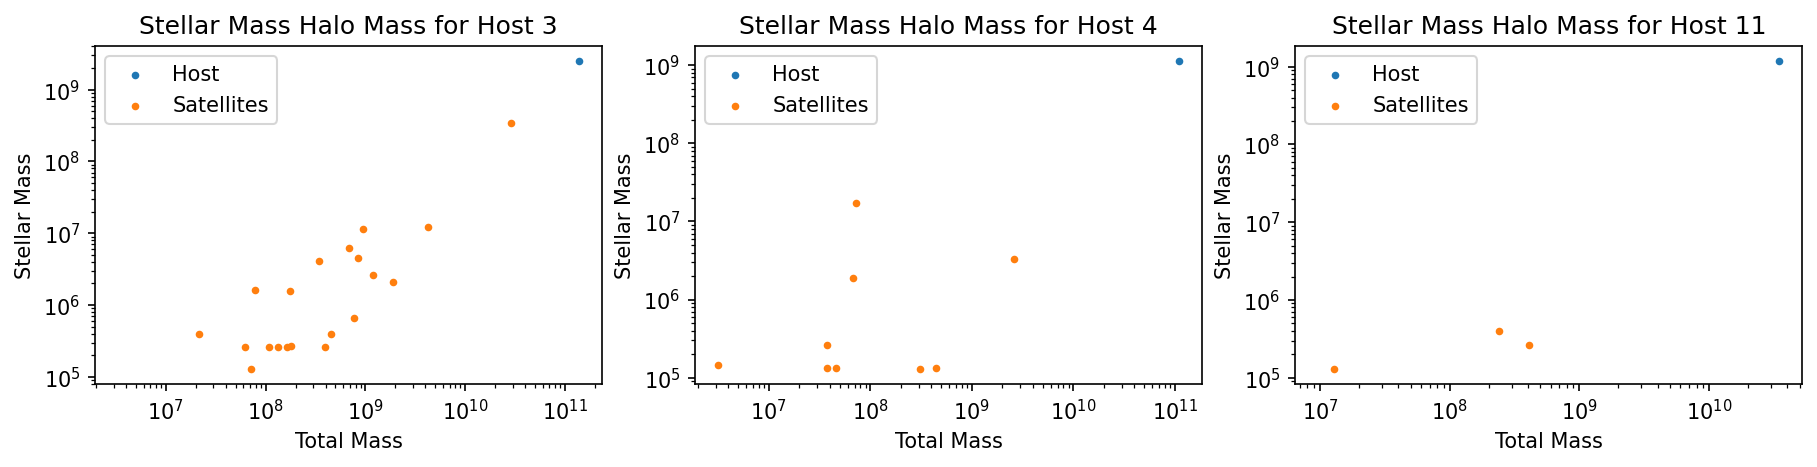

In [103]:
print(vol15_df.keys())
#make stellar mass hallo mass plots for each host and its respective satelites
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi=150, constrained_layout=True)
for i, a in enumerate(ax):
    a.scatter(vol15_df['Host Mtot'][i], vol15_df['Host M*'][i], s=7, label='Host')
    a.scatter(vol15_df['Sat Mtot'][i], vol15_df['Sat M*'][i], s=7, label='Satellites')
    a.set_xlabel('Total Mass')
    a.set_ylabel('Stellar Mass')
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend()
    host_id = vol15_df['Host Halo ID'][i]
    a.set_title(f'Stellar Mass Halo Mass for Host {host_id}')
fig.show()

153 153
107 107
6 6


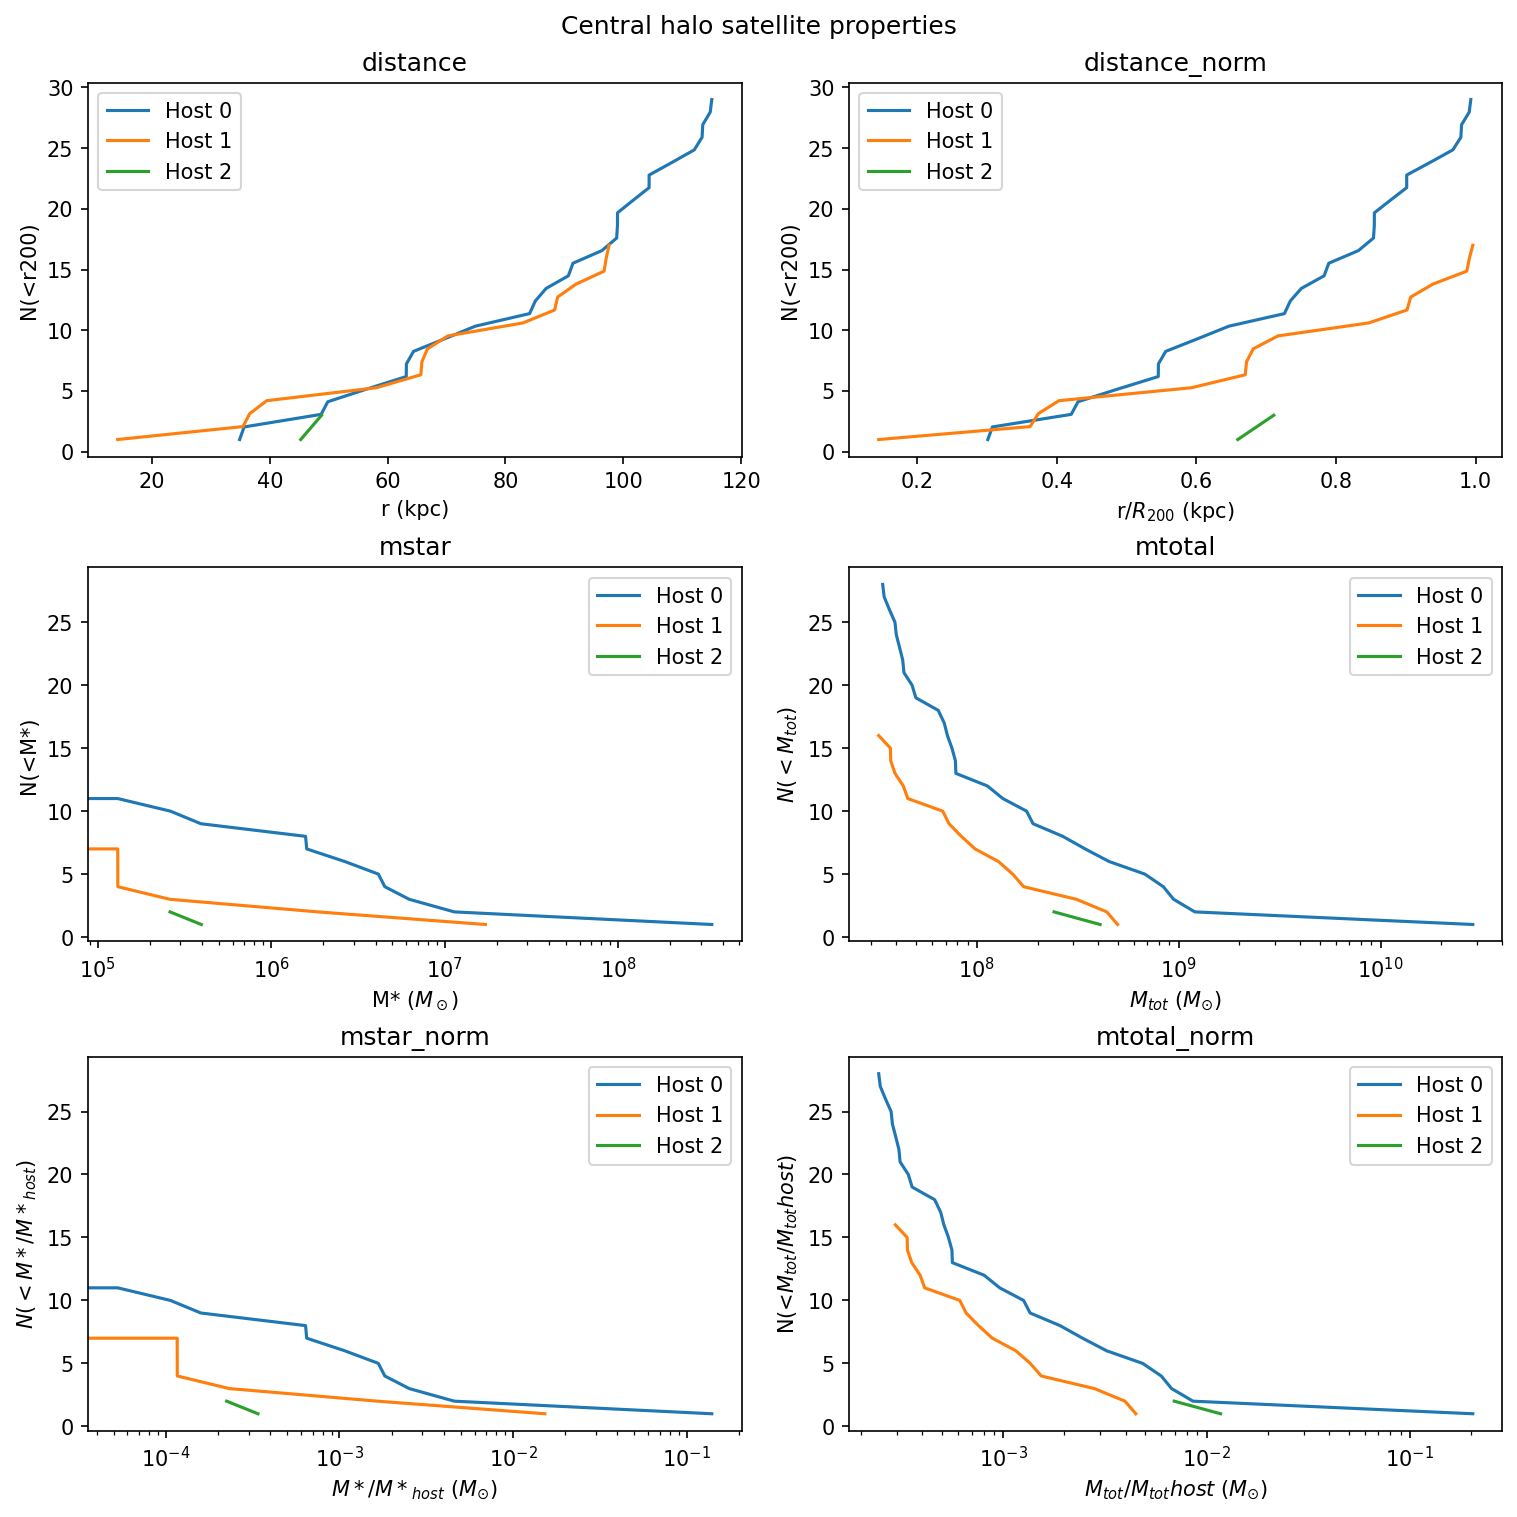

In [6]:
vol15_sim.number_plots()

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


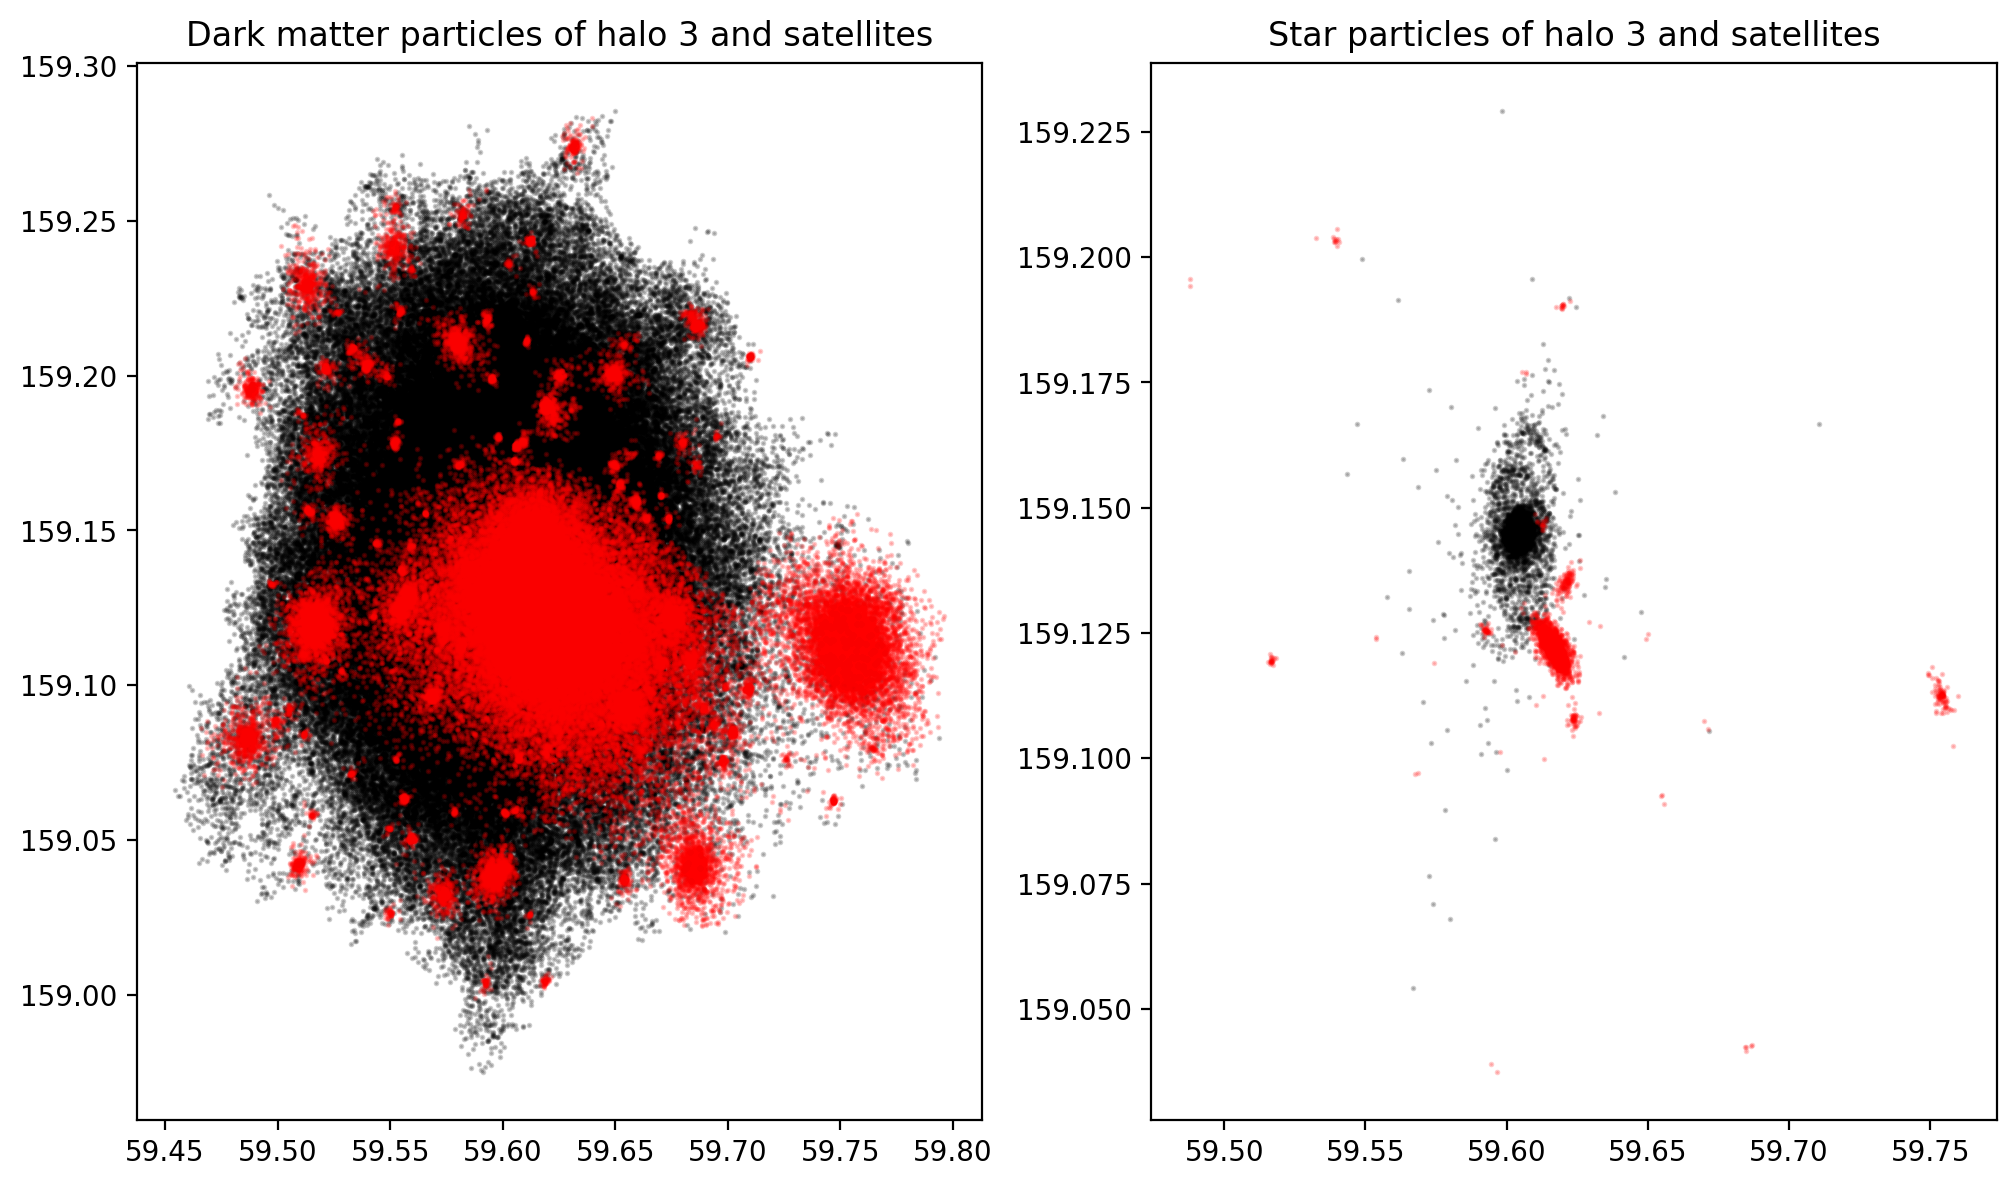

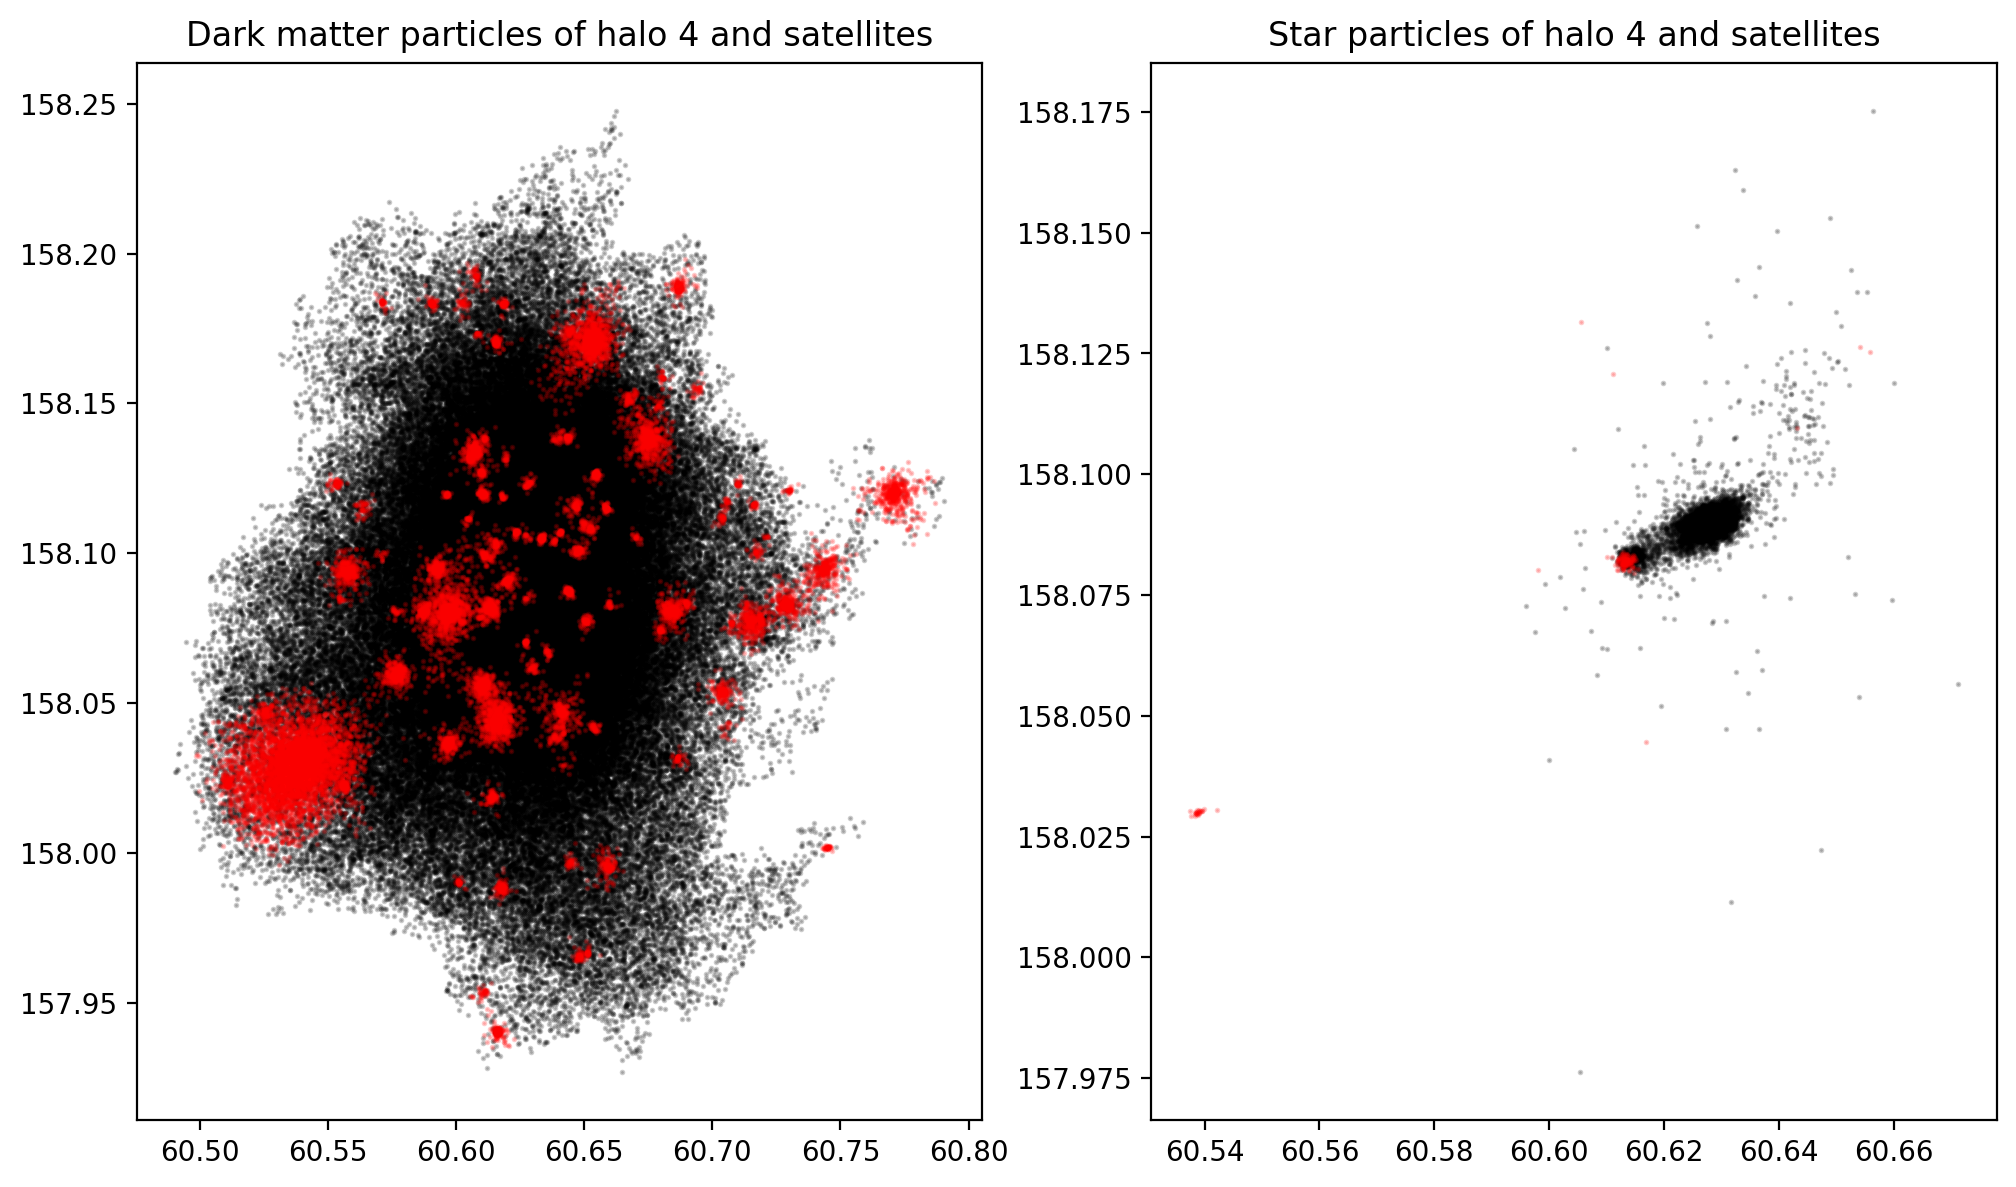

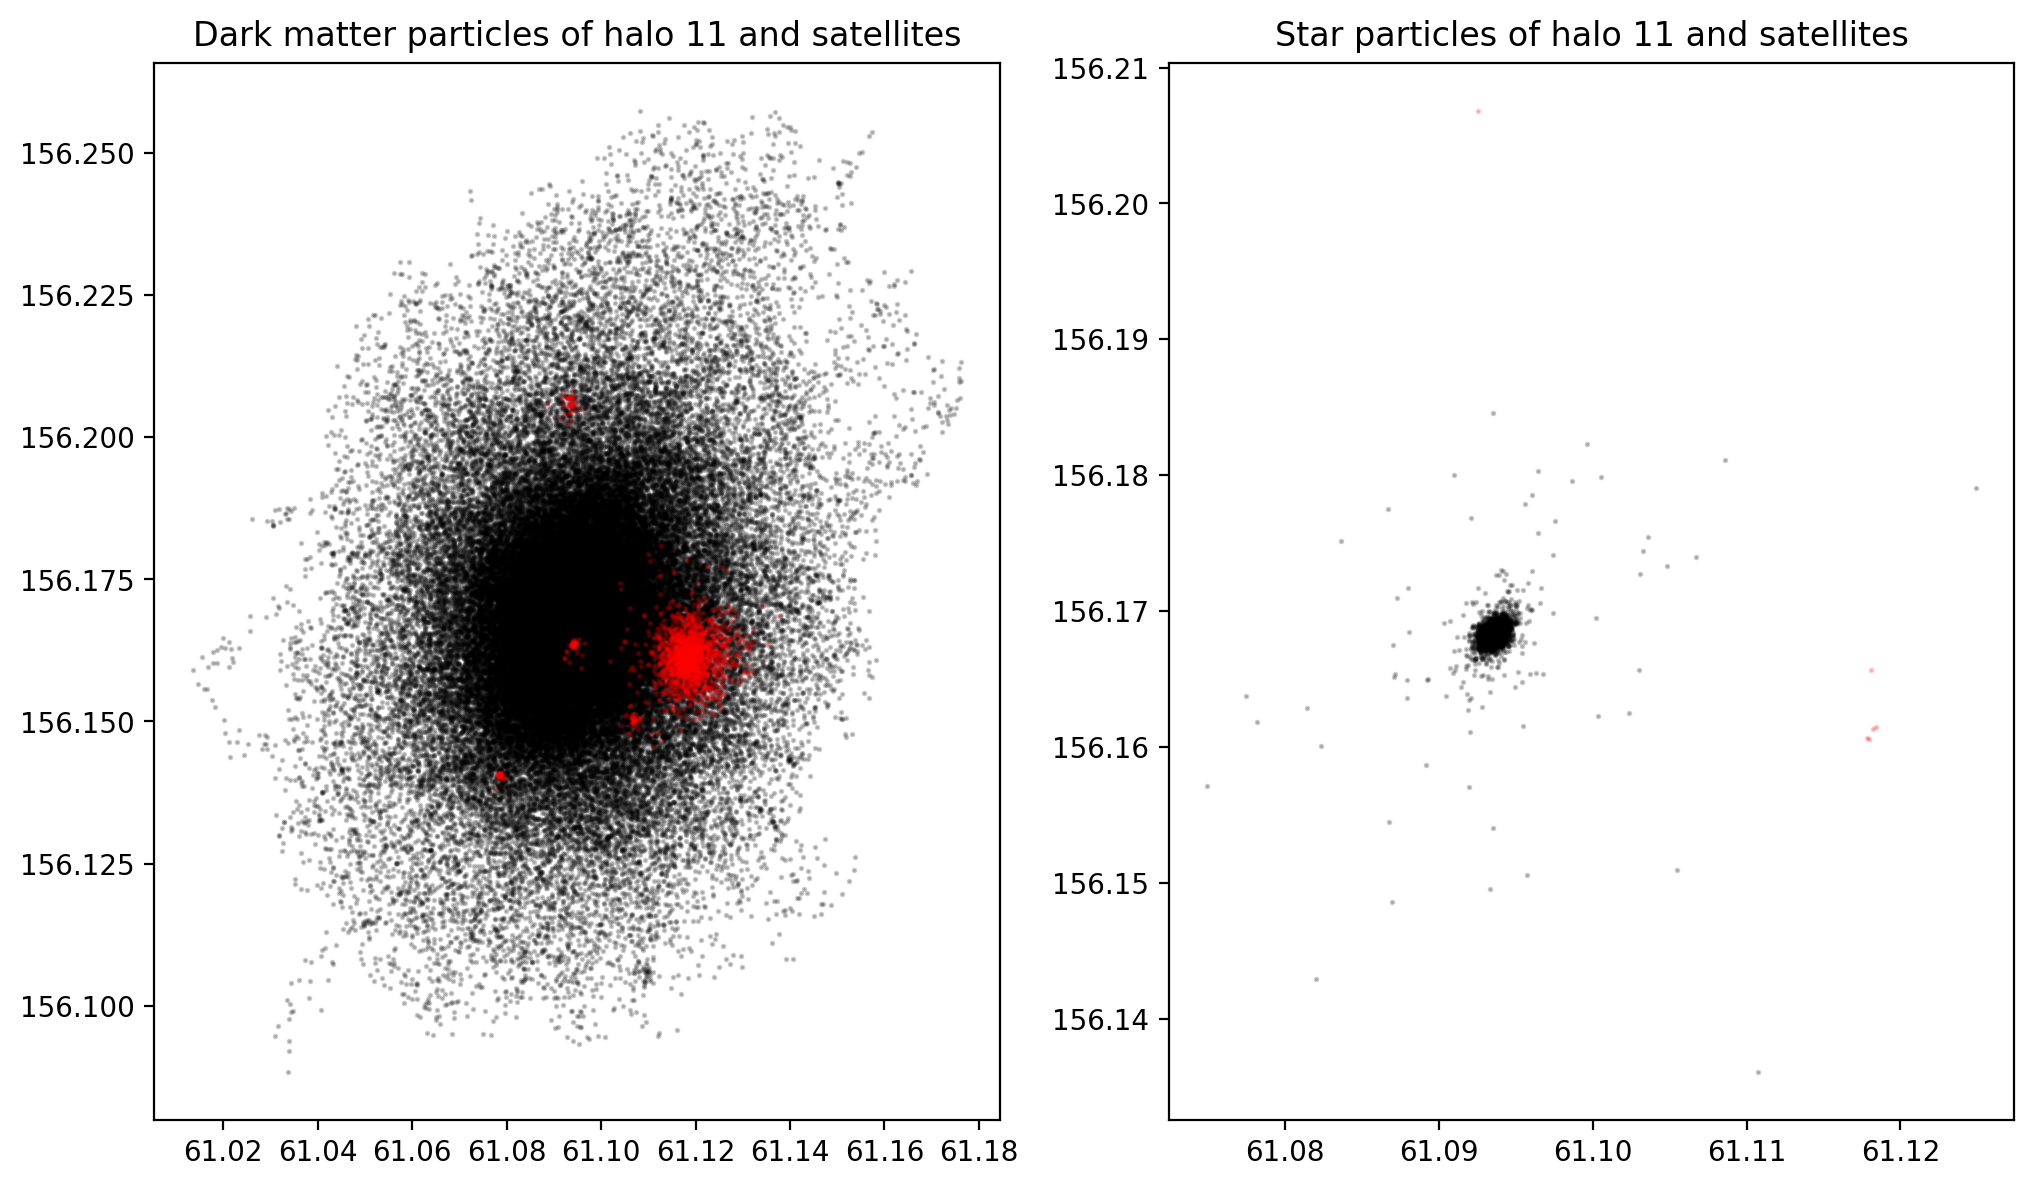

In [24]:
vol15_sim.plot_particles(0)
vol15_sim.plot_particles(1)
vol15_sim.plot_particles(2)